In [1]:
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import torch
import sys

# 캐싱된 모듈 삭제
if 'models' in sys.modules:
    del sys.modules['models']
if 'Segdataset' in sys.modules:
    del sys.modules['Segdataset']
if 'utils' in sys.modules:
    del sys.modules['utils']

# 다시 임포트
from utils import plot_confusion_matrix, get_evaluation
from models_jh import CNN
from Segdataset_jh import SegDataset,read_train_file_list
from torch.utils.data import DataLoader

In [2]:
class Args:
    def __init__(self):
        self.data_root = '/workspace/dataset/CREMA-D/test'
        self.save_root = '/workspace/UndergraduateResearchAssistant/GraduateProject/code/CREMA-D/checkpoints_jh'
        self.random_seed = 1
        self.model_kind = 'cnn'
        self.num_workers = 16
        self.n_mfcc = 20
        self.n_folds = 5

opt = Args()


In [3]:
def main():
    emotions = ['NotStressed', 'Stressed']
    all_metrics = []

    for fold in range(opt.n_folds):
        if opt.model_kind == 'cnn':
            model = CNN()

        output_emotion_list = []
        label_emotion_list = []

        mfcc_list, emotion_list = read_train_file_list(root=opt.data_root, n_mfcc=opt.n_mfcc)
        test_set = SegDataset(mfcc_list, emotion_list)
        test_iter = DataLoader(test_set, batch_size=1, drop_last=True, num_workers=opt.num_workers)

        if torch.cuda.is_available():
            device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            device = torch.device('mps')
        else:
            device = torch.device('cpu')

        model = model.to(device)

        # 모델 로드
        model.load_state_dict(torch.load(os.path.join(opt.save_root, f'fold_{fold + 1}_best_epoch.pth'), map_location=device))
        model.eval()

        with torch.no_grad():
            for index, (mfcc, emotion) in enumerate(test_iter):
                mfcc, emotion = mfcc.to(device), emotion.to(device)
                output_emotion = model(mfcc)
                output_emotion = torch.sigmoid(output_emotion)
                predicted_emotion = (output_emotion > 0.45).float()

                output_emotion_list.append(predicted_emotion.cpu().numpy())
                label_emotion_list.append(emotion.cpu().numpy())

        output_emotion_list = np.vstack(output_emotion_list)[:, 0]
        label_emotion_list = np.vstack(label_emotion_list)[:, 0]

        # 평가
        acc, precision, recall, f1 = get_evaluation(label_emotion_list, output_emotion_list)
        all_metrics.append((acc, precision, recall, f1))

        # 결과 출력
        print(f"Fold {fold + 1} - Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

        # Confusion Matrix 생성 및 저장
        plt.figure()
        plot_confusion_matrix(label_emotion_list, output_emotion_list, emotions)
        plt.title(f'Confusion Matrix - Fold {fold + 1}')
        plt.savefig(os.path.join(opt.save_root, f'confusion_matrix_fold_{fold + 1}.png'))
        plt.show()

    # 평균값 계산
    avg_metrics = np.mean(all_metrics, axis=0)
    print(f"Average - Accuracy: {avg_metrics[0]}, Precision: {avg_metrics[1]}, Recall: {avg_metrics[2]}, F1 Score: {avg_metrics[3]}")


Dataset loaded with 1489 samples.


/tmp/ipykernel_457762/1736433400.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(opt.save_root, f'fold_{fold + 1}_best_epo

(1489,)
(1489,)
(1489,)
Fold 1 - Accuracy: 0.7508394895903291, Precision: 0.848, Recall: 0.774, F1 Score: 0.809


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

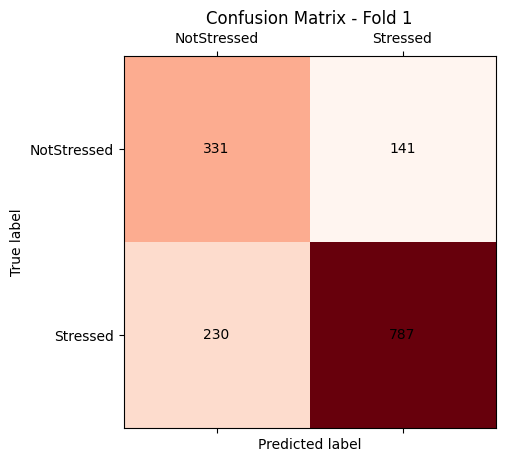

Dataset loaded with 1489 samples.


/tmp/ipykernel_457762/1736433400.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(opt.save_root, f'fold_{fold + 1}_best_epo

(1489,)
(1489,)
(1489,)
Fold 2 - Accuracy: 0.7427803895231699, Precision: 0.849, Recall: 0.758, F1 Score: 0.801


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

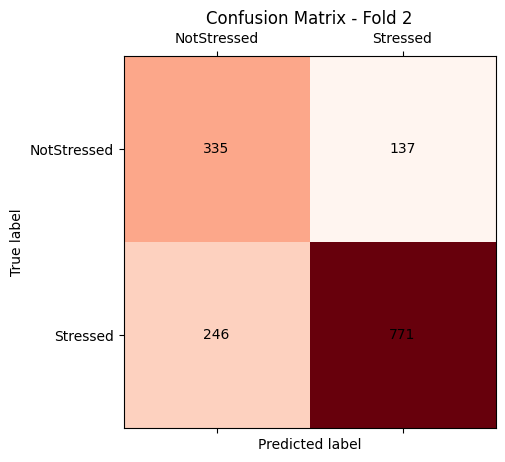

Dataset loaded with 1489 samples.


/tmp/ipykernel_457762/1736433400.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(opt.save_root, f'fold_{fold + 1}_best_epo

(1489,)
(1489,)
(1489,)
Fold 3 - Accuracy: 0.7434519811954332, Precision: 0.856, Recall: 0.751, F1 Score: 0.8


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

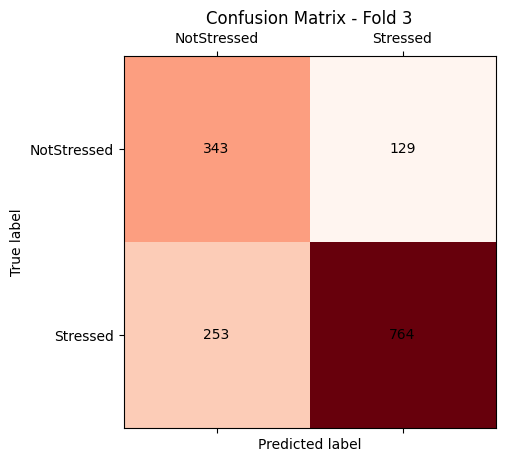

Dataset loaded with 1489 samples.


/tmp/ipykernel_457762/1736433400.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(opt.save_root, f'fold_{fold + 1}_best_epo

(1489,)
(1489,)
(1489,)
Fold 4 - Accuracy: 0.7515110812625924, Precision: 0.857, Recall: 0.763, F1 Score: 0.807


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

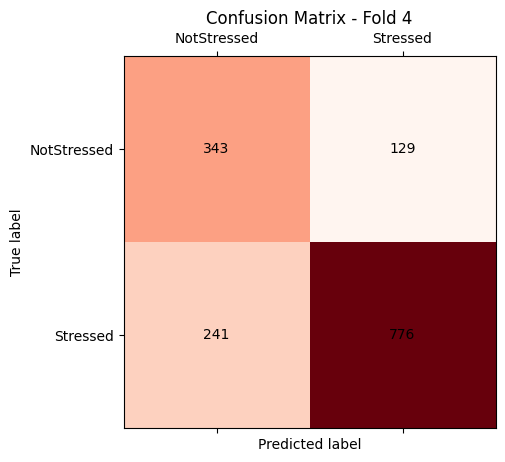

Dataset loaded with 1489 samples.


/tmp/ipykernel_457762/1736433400.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(opt.save_root, f'fold_{fold + 1}_best_epo

(1489,)
(1489,)
(1489,)
Fold 5 - Accuracy: 0.7427803895231699, Precision: 0.832, Recall: 0.782, F1 Score: 0.806


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

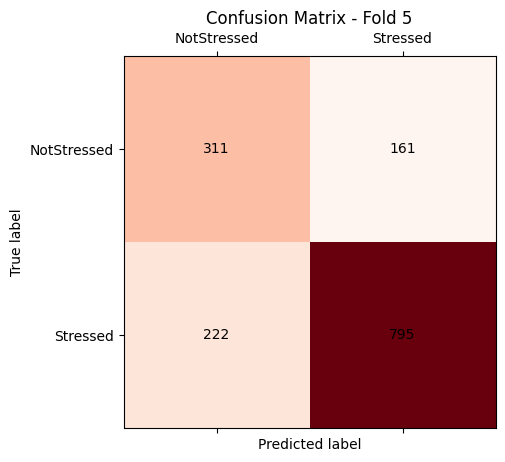

Average - Accuracy: 0.746272666218939, Precision: 0.8484, Recall: 0.7656, F1 Score: 0.8046


In [4]:
if __name__ == '__main__':
    main()